In [117]:
import numpy as np
import matplotlib.pyplot as plt
from mne.io.snirf import read_raw_snirf
from get_events_from_snirf import get_events_from_snirf
import itertools

In [2]:
path_to_snirf = "../data_hojjat/dec_nef/1_new_full_2/test_001_S001_c7bcdc0_5.snirf"
snirf = read_raw_snirf(path_to_snirf)

Loading /home/kernel/Desktop/py_test/project/data_hojjat/dec_nef/1_new_full_2/test_001_S001_c7bcdc0_5.snirf


/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/externals/pymatreader/pymatreader.py:34: DeprecationWarning: Please use `get_matfile_version` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.miobase` namespace is deprecated.
  from scipy.io.matlab.miobase import get_matfile_version


In [60]:
events_df = get_events_from_snirf(path_to_snirf);
events_df.head(15)

,Timestamp,Event,Duration,Value,Experiment,Stim,Label,File
0,22.644750,StartExperiment,575.932999,1.0,1.0,NaN,na,nan
1,22.691047,Stim,0.000000,1.0,1.0,Bee-7-1-5.Png,Bee,7_1_5.Png
2,23.657696,Stim,0.000000,1.0,1.0,Bee-7-1-8.Png,Bee,7_1_8.Png
3,24.591449,Stim,0.000000,1.0,1.0,Bee-7-1-2.Png,Bee,7_1_2.Png
4,25.542362,Stim,0.000000,1.0,1.0,Bee-7-1-12.Png,Bee,7_1_12.Png
5,26.510487,Stim,0.000000,1.0,1.0,Key-36-1-4.Png,Key,36_1_4.Png
6,27.443756,Stim,0.000000,1.0,1.0,Key-36-1-7.Png,Key,36_1_7.Png
7,28.411133,Stim,0.000000,1.0,1.0,Key-36-1-11.Png,Key,36_1_11.Png
8,29.361902,Stim,0.000000,1.0,1.0,Key-36-1-14.Png,Key,36_1_14.Png
9,30.354241,Stim,0.000000,1.0,1.0,Key-36-1-5.Png,Key,36_1_5.Png


In [63]:
events_df.Label.unique()

array(['na', 'Bee', 'Key', 'Dolphin', 'Cockroach', 'Chicken', 'Spider',
       'Car', 'Beatle', 'Peacock', 'Turtle', 'Fish', 'Bicycle',
       'Airplane', 'Scissor', 'Dog', 'Gecko', 'Rabbit', 'Mouse', 'Whale',
       'Hammer', 'Horse', 'Ants', 'Chair', 'Umbrella', 'Giraffe', 'Snake',
       'Sheep', 'Cat', 'Butterfly', 'Fly', 'Catterpilar', 'Bird',
       'GuineaPig', 'Bat', 'Guitar', 'Grasshoper', 'Shark', 'Cellphone',
       'Worm', 'Frog'], dtype=object)

In [66]:
def get_times(df, key):
    times = df[df.Label == key]['Timestamp'].values;
    return times

In [67]:
bee_times = get_times(events_df, 'Bee')
key_times = get_times(events_df, 'Key')

In [3]:
channel_names = [x['ch_name'] for x in snirf.info['chs']]
is_hbo = np.array([1 if channel_name.endswith(
    'HbO') else 0 for channel_name in channel_names], dtype=bool)
channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']]

In [4]:
data = snirf.get_data()

In [5]:
data.shape

(4168, 4316)

/tmp/ipykernel_14668/1863943196.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for bee in bee_times.astype(np.int):


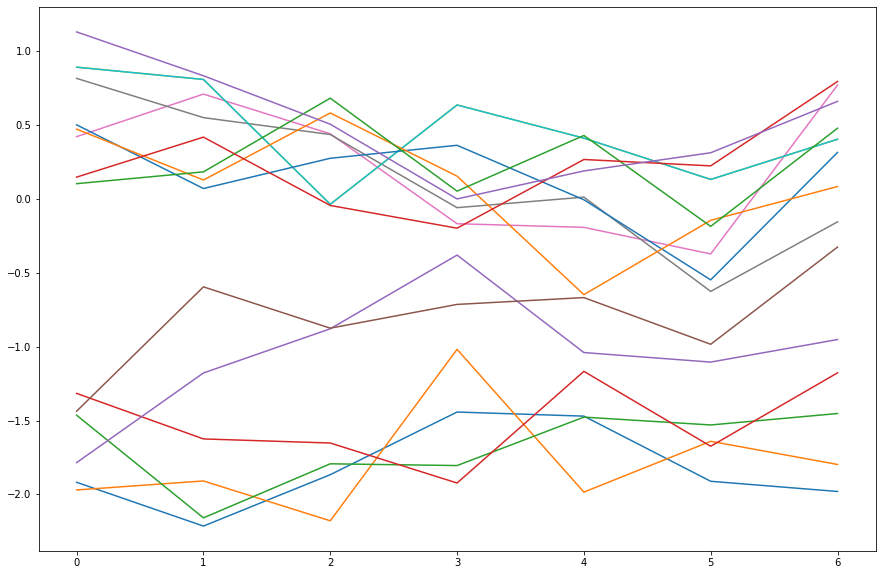

In [32]:
ax, fig = plt.subplots(figsize=(15, 10))
for bee in bee_times.astype(np.int):
    fig.plot(data[0, bee*7:(bee+1)*7])


In [119]:
def get_data(data, channels, times, index, window_size, sample_rate):
    lst = [data[channel, (time+index)*sample_rate: (time+index+window_size)*sample_rate] for time, channel in itertools.product(times.astype(int), channels)]
    arr = np.array(lst)
    return arr

In [163]:
window_size = 1
sampling_rate = 7
channels = [0, 1]
index= 6
bee_data = get_data(data, channels, bee_times, index, window_size, sampling_rate)
key_data = get_data(data, channels, key_times, index, window_size, sampling_rate)

In [126]:
bee_data.shape

(30, 7)

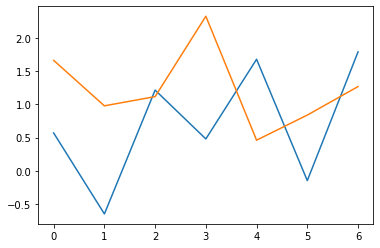

In [164]:
plt.plot(np.mean(bee_data, axis=0))
plt.plot(np.mean(key_data, axis=0))

In [135]:
def data_to_feature(data):
    shape = np.shape(data)
    features = np.ones((shape[0], 3))
    features[:, 0] = np.mean(data, axis = 1)
    features[:, 1] = np.min(data, axis = 1)
    features[:, 2] = np.max(data, axis = 1)
    return features

In [165]:
bee_features = data_to_feature(bee_data)
key_features = data_to_feature(key_data)

In [140]:
bee_features.shape

(30, 3)

In [142]:
key_features.shape

(30, 3)

In [160]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [166]:
X = np.vstack((bee_features, key_features))
y = np.hstack((np.ones(30), np.ones(30)*2))

In [167]:
clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto'))
                    # SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [168]:
clf.score(X, y)

0.6166666666666667

In [159]:
len(bee_features)

30